In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Step 1: Read and merge datasets
task_events = pd.read_csv('/content/combined_task_events.csv')
task_usage = pd.read_csv('/content/combined_task_usage.csv')

In [ ]:
task_data = pd.merge(task_events, task_usage, on=['job ID', 'task index', 'machine ID'], how='inner')

# Step 2: Feature selection
selected_features = ['CPU rate', 'canonical memory usage', 'assigned memory usage',
                     'unmapped page cache', 'total page cache', 'maximum memory usage',
                     'disk I/O time', 'local disk space usage']

task_data = task_data[selected_features]


In [ ]:
# Step 3: Handling missing values
task_data.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Step 4: Preprocessing - Scaling the data
scaler = StandardScaler()
task_data_scaled = scaler.fit_transform(task_data)

<ipython-input-62-7aa38da95bd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:

# Step 5: Segmenting the time series and generating labels
def top_down_plr(data, max_error):
    def fit_line(x, y):
        return np.polyfit(x, y, 1)

    def segment_error(y, y_hat):
        return np.sum((y - y_hat) ** 2)

    def plr_recursive(x, y, max_error):
        best_fit = fit_line(x, y)
        y_hat = np.polyval(best_fit, x)
        error = segment_error(y, y_hat)

        if error <= max_error or len(x) < 3:
            return [(x[0], y[0]), (x[-1], y[-1])]
        else:
            best_error = float('inf')
            best_index = None
            for i in range(1, len(x) - 1):
                left_fit = fit_line(x[:i + 1], y[:i + 1])
                right_fit = fit_line(x[i:], y[i:])
                left_y_hat = np.polyval(left_fit, x[:i + 1])
                right_y_hat = np.polyval(right_fit, x[i:])
                total_error = segment_error(y[:i + 1], left_y_hat) + segment_error(y[i:], right_y_hat)
                if total_error < best_error:
                    best_error = total_error
                    best_index = i

            left_segment = plr_recursive(x[:best_index + 1], y[:best_index + 1], max_error)
            right_segment = plr_recursive(x[best_index:], y[best_index:], max_error)
            return left_segment[:-1] + right_segment

    x = np.arange(len(data))
    y = data
    return plr_recursive(x, y, max_error)

def generate_turning_point_labels(data):
    labels = np.zeros(len(data))  # Initialize labels with zeros
    for i in range(1, len(data) - 1):
        x0 = data[i - 1]
        x1 = data[i]
        x2 = data[i + 1]

        if x1 < x0 and x1 < x2:
            labels[i] = 1  # Valley point
        elif x1 > x0 and x1 > x2:
            labels[i] = 1  # Peak point

    return labels

def extract_features_from_segments(segments, data, labels, window_size):
    X, Y = [], []
    for i in range(len(segments) - window_size):
        window_data = data[int(segments[i][0]):int(segments[i + window_size][0])]
        window_labels = labels[int(segments[i + window_size][0])]

        fcw = window_data[-1].reshape(1, -1)  # Reshape to (1, number of features)
        favg = np.mean(window_data, axis=0).reshape(1, -1)
        fvar = np.var(window_data, axis=0).reshape(1, -1)
        xup = np.sum(np.abs(np.diff(window_data, axis=0)) * (np.diff(window_data, axis=0) > 0), axis=0).reshape(1, -1)
        xdown = np.sum(np.abs(np.diff(window_data, axis=0)) * (np.diff(window_data, axis=0) < 0), axis=0).reshape(1, -1)
        frsi = np.divide(xup, (xup + xdown), out=np.zeros_like(xup), where=(xup + xdown) != 0).reshape(1, -1)  # Handle division by zero
        fasc = np.sum(np.abs(np.diff(window_data, axis=0)), axis=0).reshape(1, -1)
        second_order_diff = np.diff(window_data, n=2, axis=0)
        fmsdc = np.mean(second_order_diff, axis=0).reshape(1, -1)
        slope = np.polyfit(range(len(window_data)), window_data, 1)[0].reshape(1, -1)  # Reshape to (1, number of features)

        features = np.concatenate([fcw, favg, fvar, frsi, fasc, fmsdc, slope], axis=1).flatten()
        X.append(features)
        Y.append(window_labels)

    return np.array(X), np.array(Y)

def train_lstm_model(X_train, Y_train, X_test, Y_test, window_size, num_time_steps):
    # Reshape input to be [samples, time steps, features] required for LSTM
    X_train = X_train.reshape(X_train.shape[0], window_size, num_time_steps)
    X_test = X_test.reshape(X_test.shape[0], window_size, num_time_steps)

    # Define the LSTM model
    input_raw = Input(shape=(window_size, num_time_steps))
    lstm_raw = LSTM(50, return_sequences=True)(input_raw)
    lstm_raw = LSTM(50, return_sequences=False)(lstm_raw)
    output = Dense(1, activation='sigmoid')(lstm_raw)

    # Compile the model
    model = Model(inputs=input_raw, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_test, Y_test))

    # Predict and evaluate turning points
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = (train_predict > 0.5).astype(int)
    test_predict = (test_predict > 0.5).astype(int)

    # Compute precision, recall, F1 score, and accuracy
    train_precision = precision_score(Y_train, train_predict)
    train_recall = recall_score(Y_train, train_predict)
    train_f1 = f1_score(Y_train, train_predict)
    train_accuracy = accuracy_score(Y_train, train_predict)

    test_precision = precision_score(Y_test, test_predict)
    test_recall = recall_score(Y_test, test_predict)
    test_f1 = f1_score(Y_test, test_predict)
    test_accuracy = accuracy_score(Y_test, test_predict)

    print(f'Train Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, Accuracy: {train_accuracy:.4f}')
    print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, Accuracy: {test_accuracy:.4f}')

    return model, history

# Assuming task_data_scaled is already defined and scaled
task_data_scaled = np.random.rand(1000, 10)  # Replace with your actual scaled data

max_error = 0.01
window_size = 5

# Generate segments
segments = top_down_plr(task_data_scaled[:, 0], max_error)

# Generate turning point labels
turning_point_labels = generate_turning_point_labels(task_data_scaled[:, 0])

# Extract features from segments
X, Y = extract_features_from_segments(segments, task_data_scaled, turning_point_labels, window_size)

# Verify the feature extraction
if len(X) > 0:  # Check if X is not empty
    print(f'Extracted features per window: {X.shape[1]}')
else:
    print("No features extracted.")

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print dimensions and size of X_train before reshaping
print(f'Before reshaping - X_train shape: {X_train.shape}, X_train size: {X_train.size}')

# Verify the number of features per window
if X_train.shape[0] > 0:  # Check if X_train is not empty
    num_features_per_window = X_train.shape[1]
    print(f'Number of features per window: {num_features_per_window}')

    # Print window size for verification
    print(f'Window size: {window_size}')

    # Calculate the number of time steps
    num_time_steps = num_features_per_window // window_size
    print(f'Number of time steps: {num_time_steps}')
else:
    print("No training data available.")

# Train the LSTM model if data is available
if X_train.shape[0] > 0:
    model, history = train_lstm_model(X_train, Y_train, X_test, Y_test, window_size, num_time_steps)
else:
    print("Insufficient data for training the model.")

Extracted features per window: 70
Before reshaping - X_train shape: (670, 70), X_train size: 46900
Number of features per window: 70
Window size: 5
Number of time steps: 14
Epoch 1/10
11/11 [==============================] - 5s 76ms/step - loss: 0.6510 - accuracy: 0.6731 - val_loss: 0.6279 - val_accuracy: 0.6845
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6071 - accuracy: 0.7090 - val_loss: 0.6416 - val_accuracy: 0.6845
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6051 - accuracy: 0.7090 - val_loss: 0.6280 - val_accuracy: 0.6845
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6053 - accuracy: 0.7090 - val_loss: 0.6298 - val_accuracy: 0.6845
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6033 - accuracy: 0.7090 - val_loss: 0.6294 - val_accuracy: 0.6845
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.6049 - accuracy: 0.7090 - val_loss: 0.6327 - va

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Step 1: Read and merge datasets
task_events = pd.read_csv('/content/trimmed_combined_task_events.csv')
task_usage = pd.read_csv('/content/trimmed_combined_task_usage.csv')

# Merge datasets
task_data = pd.merge(task_events, task_usage, on=['job ID', 'task index', 'machine ID'], how='inner')

# Step 2: Feature selection
selected_features = ['CPU rate', 'canonical memory usage', 'assigned memory usage',
                     'unmapped page cache', 'total page cache', 'maximum memory usage',
                     'disk I/O time', 'local disk space usage']

task_data = task_data[selected_features]

# Step 3: Handling missing values
task_data.fillna(method='ffill', inplace=True)

# Step 4: Preprocessing - Scaling the data
scaler = StandardScaler()
task_data_scaled = scaler.fit_transform(task_data)

# Step 5: Segmenting the time series and generating labels
def top_down_plr(data, max_error):
    def fit_line(x, y):
        return np.polyfit(x, y, 1)

    def segment_error(y, y_hat):
        return np.sum((y - y_hat) ** 2)

    def plr_recursive(x, y, max_error):
        best_fit = fit_line(x, y)
        y_hat = np.polyval(best_fit, x)
        error = segment_error(y, y_hat)

        if error <= max_error or len(x) < 3:
            return [(x[0], y[0]), (x[-1], y[-1])]
        else:
            best_error = float('inf')
            best_index = None
            for i in range(1, len(x) - 1):
                left_fit = fit_line(x[:i + 1], y[:i + 1])
                right_fit = fit_line(x[i:], y[i:])
                left_y_hat = np.polyval(left_fit, x[:i + 1])
                right_y_hat = np.polyval(right_fit, x[i:])
                total_error = segment_error(y[:i + 1], left_y_hat) + segment_error(y[i:], right_y_hat)
                if total_error < best_error:
                    best_error = total_error
                    best_index = i

            left_segment = plr_recursive(x[:best_index + 1], y[:best_index + 1], max_error)
            right_segment = plr_recursive(x[best_index:], y[best_index:], max_error)
            return left_segment[:-1] + right_segment

    x = np.arange(len(data))
    y = data
    return plr_recursive(x, y, max_error)

def generate_turning_point_labels(data):
    labels = np.zeros(len(data))  # Initialize labels with zeros
    for i in range(1, len(data) - 1):
        x0 = data[i - 1]
        x1 = data[i]
        x2 = data[i + 1]

        if x1 < x0 and x1 < x2:
            labels[i] = 1  # Valley point
        elif x1 > x0 and x1 > x2:
            labels[i] = 1  # Peak point

    return labels

def extract_features_from_segments(segments, data, labels, window_size):
    X, Y = [], []
    for i in range(len(segments) - window_size):
        window_data = data[int(segments[i][0]):int(segments[i + window_size][0])]
        window_labels = labels[int(segments[i + window_size][0])]

        fcw = window_data[-1].reshape(1, -1)  # Reshape to (1, number of features)
        favg = np.mean(window_data, axis=0).reshape(1, -1)
        fvar = np.var(window_data, axis=0).reshape(1, -1)
        xup = np.sum(np.abs(np.diff(window_data, axis=0)) * (np.diff(window_data, axis=0) > 0), axis=0).reshape(1, -1)
        xdown = np.sum(np.abs(np.diff(window_data, axis=0)) * (np.diff(window_data, axis=0) < 0), axis=0).reshape(1, -1)
        frsi = np.divide(xup, (xup + xdown), out=np.zeros_like(xup), where=(xup + xdown) != 0).reshape(1, -1)  # Handle division by zero
        fasc = np.sum(np.abs(np.diff(window_data, axis=0)), axis=0).reshape(1, -1)
        second_order_diff = np.diff(window_data, n=2, axis=0)
        fmsdc = np.mean(second_order_diff, axis=0).reshape(1, -1)
        slope = np.polyfit(range(len(window_data)), window_data, 1)[0].reshape(1, -1)  # Reshape to (1, number of features)

        features = np.concatenate([fcw, favg, fvar, frsi, fasc, fmsdc, slope], axis=1).flatten()
        X.append(features)
        Y.append(window_labels)

    return np.array(X), np.array(Y)

# Step 6: Segmenting the time series data
max_error = 0.01
segments = top_down_plr(task_data_scaled[:50000, 0], max_error)

# Step 7: Generating labels for turning points
turning_point_labels = generate_turning_point_labels(task_data_scaled[:50000, 0])

# Step 8: Extracting features
window_size = 5  # Adjust window size as needed
X, Y = extract_features_from_segments(segments, task_data_scaled, turning_point_labels, window_size)

# Verify the feature extraction
if len(X) > 0:  # Check if X is not empty
    print(f'Extracted features per window: {X.shape[1]}')
else:
    print("No features extracted.")

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# Predict and evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_precision = precision_score(Y_train, train_predict)
train_recall = recall_score(Y_train, train_predict)
train_f1 = f1_score(Y_train, train_predict)
train_accuracy = accuracy_score(Y_train, train_predict)

test_precision = precision_score(Y_test, test_predict)
test_recall = recall_score(Y_test, test_predict)
test_f1 = f1_score(Y_test, test_predict)
test_accuracy = accuracy_score(Y_test, test_predict)

print(f'Train Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, Accuracy: {train_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, Accuracy: {test_accuracy:.4f}')


Extracted features per window: 56
Train Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Accuracy: 1.0000
Test Precision: 0.6942, Recall: 0.9385, F1 Score: 0.7981, Accuracy: 0.6777


In [5]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, Y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')


Cross-Validation Accuracy: 0.6089 ± 0.0554


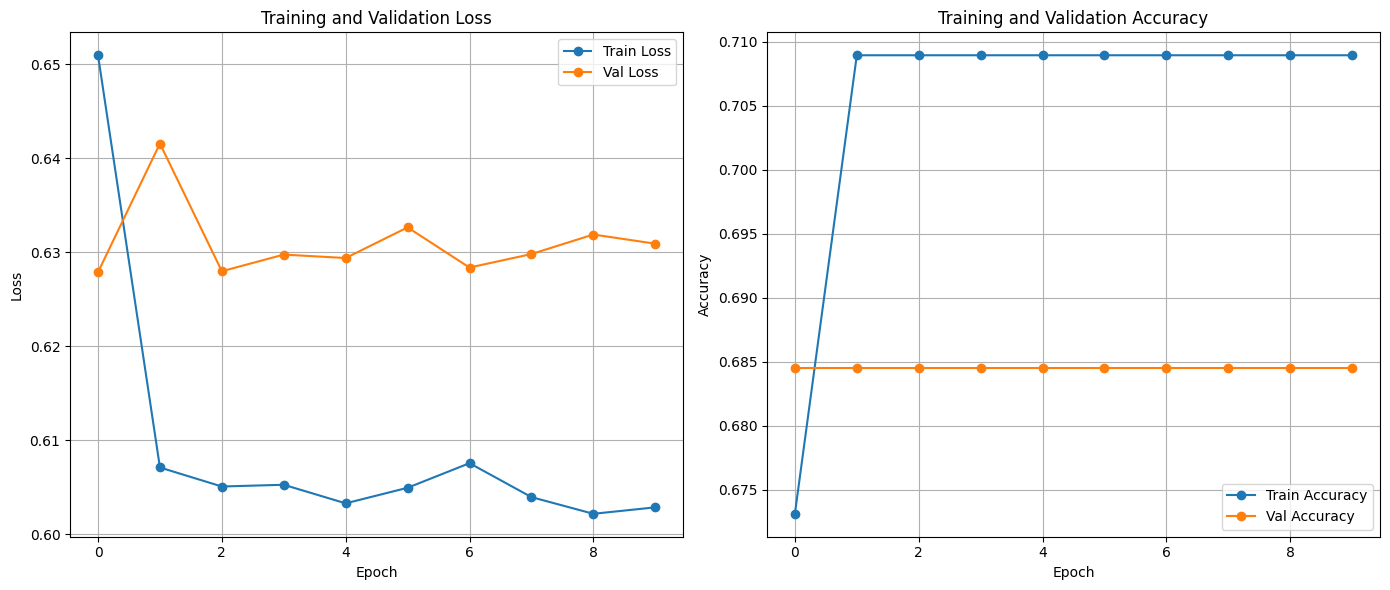

6/6 [==============================] - 0s 3ms/step


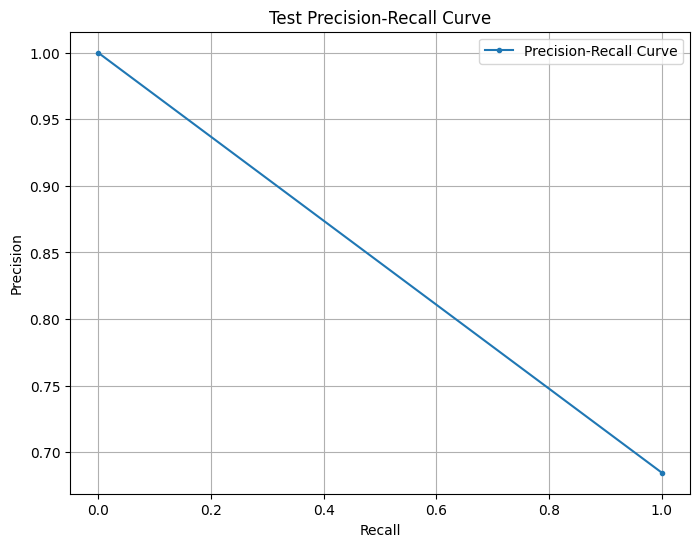

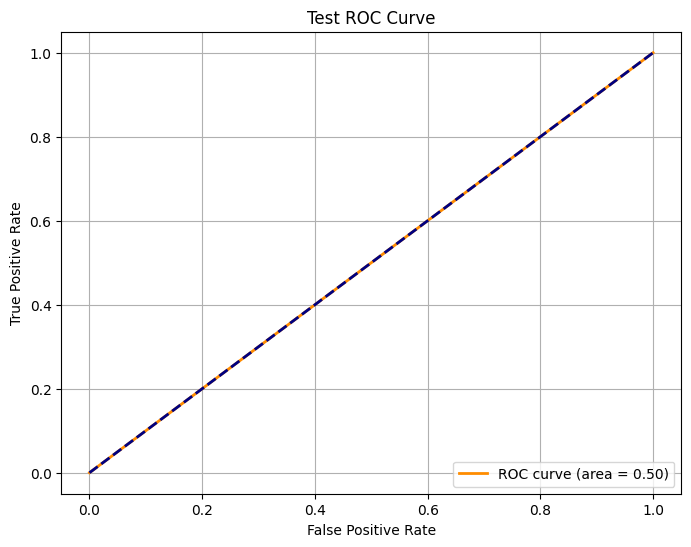

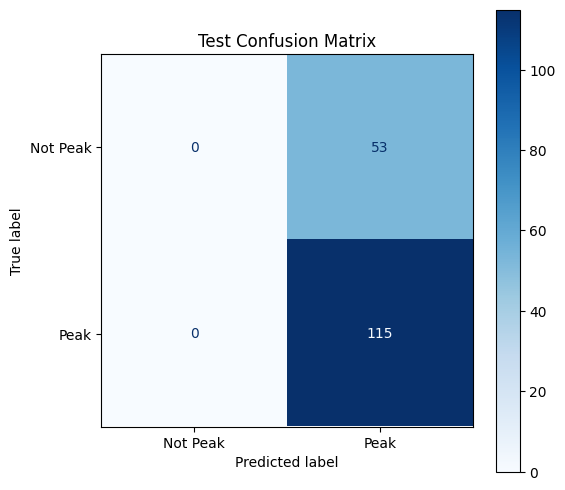

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc

def plot_metrics(history):
    plt.figure(figsize=(14, 6))  # Increase figure size for better visibility

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)  # Add gridlines for better readability

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)  # Add gridlines for better readability

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

def plot_precision_recall_curve(y_true, y_scores, title):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))  # Increase figure size
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.grid(True)  # Add gridlines for better readability
    plt.show()

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))  # Increase figure size
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)  # Add gridlines for better readability
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Peak', 'Peak'])
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(title)
    plt.grid(False)  # Remove gridlines for confusion matrix
    plt.show()

# Assuming X_train_reshaped, X_test_reshaped, Y_train, Y_test, and history are defined as in your previous code

# Predict and evaluate turning points
if X_train_reshaped.shape[0] > 0:
    plot_metrics(history)

    train_predict = model.predict(X_train_reshaped).round()
    test_predict = model.predict(X_test_reshaped).round()

    # Ensure Y_test and test_predict have the same number of samples
    min_len = min(len(Y_test), len(test_predict))
    Y_test = Y_test[:min_len]
    test_predict = test_predict[:min_len]

    plot_precision_recall_curve(Y_test, test_predict, 'Test Precision-Recall Curve')
    plot_roc_curve(Y_test, test_predict, 'Test ROC Curve')
    plot_confusion_matrix(Y_test, test_predict, 'Test Confusion Matrix')
else:
    print("Insufficient data for plotting.")
